In [1]:

import numpy as np
import wfdb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import pywt
from tqdm import tqdm
import neurokit2 as nk


In [2]:

# Configure logging
import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


In [3]:

# Constants and Configuration
DATASET_PATH = "C:\\Users\\mhame\\pfa_project\\ECG-Heartbeat-Classification\\mit-bih-arrhythmia-database"
RECORD_IDS = ['100', '101', '102', '103', '104', '105', '106', '107', '108', '109', 
              '111', '112', '113', '114', '115', '116', '117', '118', '119', '121', 
              '122', '123', '124', '200', '201', '202', '203', '205', '207', '208', 
              '209', '210', '212', '213', '214', '215', '217', '219', '220', '221', 
              '222', '223', '228', '230', '231', '232', '233', '234']

FS = 360  # Sampling frequency
WINDOW_SIZE = 360  # 1-second windows
OVERLAP = 180      # 50% overlap

# Enhanced label mapping with more beat types
LABEL_MAPPING = {
    'N': 0,   # Normal beat
    'L': 1,   # Left bundle branch block beat
    'R': 2,   # Right bundle branch block beat
    'A': 3,   # Atrial premature beat
    'V': 4,   # Premature ventricular contraction
    '/': 5,   # Paced beat
    'f': 6,   # Fusion of ventricular and normal beat
    'F': 7,   # Fusion beat
    'j': 8,   # Nodal (junctional) escape beat
    'a': 9,   # Aberrated atrial premature beat
    'J': 10,  # Nodal (junctional) premature beat
    'e': 11   # Ventricular escape beat
}


In [4]:

# %%
# Enhanced Preprocessing Functions
def preprocess_signal(signal, fs=360):
    """Apply advanced preprocessing including bandpass filtering and detrending"""
    # Clean using neurokit (more robust than simple filtering)
    try:
        cleaned = nk.ecg_clean(signal, sampling_rate=fs, method="neurokit")
    except:
        # Fallback to bandpass filter if neurokit fails
        from scipy.signal import butter, filtfilt
        nyquist = 0.5 * fs
        low = 0.5 / nyquist
        high = 40 / nyquist
        b, a = butter(4, [low, high], btype='band')
        cleaned = filtfilt(b, a, signal)
    
    # Remove baseline wander
    baseline = nk.signal_filter(cleaned, sampling_rate=fs, lowcut=0.5, highcut=None, method='butterworth')
    return cleaned - baseline


In [ ]:
import warnings
import numpy as np
from neurokit2 import hrv_time

# 1. Configure warning suppression at the start of your script
warnings.filterwarnings("ignore", category=RuntimeWarning, module="neurokit2.hrv.hrv_time")
warnings.filterwarnings("ignore", category=RuntimeWarning, module="numpy.core.fromnumeric")
warnings.filterwarnings("ignore", category=RuntimeWarning, module="numpy.core._methods")

# 2. Enhanced feature extraction with complete protection
def extract_robust_features(segment, fs):
    """Feature extraction with full protection against empty/nan values"""
    features = []
    
    # Helper function for safe calculations
    def safe_stats(data):
        if len(data) == 0:
            return 0, 0, 0, 0, 0, 0
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            return (
                np.nanmean(data),
                np.nanstd(data),
                np.nanmedian(data),
                np.nanmax(data) - np.nanmin(data),
                np.nanpercentile(data, 25),
                np.nanpercentile(data, 75)
            )
    
    # Time-domain features (protected)
    mean, std, median, rng, q25, q75 = safe_stats(segment)
    features.extend([mean, std, median, rng, q25, q75])
    
    # Frequency-domain features (protected)
    try:
        fft = np.abs(np.fft.rfft(segment))
        freqs = np.fft.rfftfreq(len(segment), 1/fs)
        for (low, high) in [(0.5, 5), (5, 15), (15, 40)]:
            band = fft[(freqs >= low) & (freqs <= high)]
            b_mean, b_std, _, _, _, _ = safe_stats(band)
            features.extend([b_mean, b_std])
    except:
        features.extend([0]*6)  # 3 bands * 2 features
    
    # Wavelet features (protected)
    try:
        coeffs = pywt.wavedec(segment, 'db4', level=4)
        for coeff in coeffs:
            c_mean, c_std, c_med, _, _, _ = safe_stats(coeff)
            features.extend([c_mean, c_std, c_med])
    except:
        features.extend([0]*(3*5))  # 5 levels * 3 features
    
    # HRV features with multiple fallbacks
    hrv_features = {
        'HRV_MeanNN': 0,
        'HRV_SDNN': 0,
        'HRV_RMSSD': 0,
        'HRV_pNN50': 0,
        'HRV_MedianNN': 0
    }
    
    try:
        cleaned = nk.ecg_clean(segment, sampling_rate=fs)
        rpeaks = nk.ecg_findpeaks(cleaned, sampling_rate=fs, method="kalidas2017")
        
        if len(rpeaks["ECG_R_Peaks"]) >= 4:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                hrv = nk.hrv_time(rpeaks, sampling_rate=fs)
                for key in hrv_features:
                    val = hrv[key].iloc[0] if not np.isnan(hrv[key].iloc[0]) else 0
                    hrv_features[key] = val
    except:
        pass
    
    features.extend(hrv_features.values())
    return np.array(features)

# 3. Processing function with progress tracking
def process_record_safely(record_id):
    try:
        record = wfdb.rdrecord(f"{DATASET_PATH}/{record_id}")
        annotations = wfdb.rdann(f"{DATASET_PATH}/{record_id}", 'atr')
        
        # Select best available lead
        lead_idx = 1 if record.n_sig > 1 else 0
        signal = preprocess_signal(record.p_signal[:, lead_idx], FS)
        
        features = []
        labels = []
        
        for i in range(0, len(signal) - WINDOW_SIZE + 1, WINDOW_SIZE - OVERLAP):
            segment = signal[i:i + WINDOW_SIZE]
            features.append(extract_robust_features(segment, FS))
            
            # Annotation alignment with validation
            center = i + WINDOW_SIZE//2
            valid_anns = [a for a in annotations.sample 
                         if abs(a - center) <= FS//2]
            if valid_anns:
                closest = min(valid_anns, key=lambda x: abs(x - center))
                symbol = annotations.symbol[annotations.sample.tolist().index(closest)]
                labels.append(LABEL_MAPPING.get(symbol, -1))
            else:
                labels.append(-1)
        
        return np.array(features), np.array(labels)
    except Exception as e:
        logger.error(f"Error in {record_id}: {str(e)}")
        return None, None

In [6]:
def plot_problematic_segment(record_id, start_sample, duration=5*360):
    record = wfdb.rdrecord(f"{DATASET_PATH}/{record_id}")
    signal = record.p_signal[start_sample:start_sample+duration, 0]
    plt.plot(signal)
    plt.title(f"Problematic Segment in {record_id}")
    plt.show()


In [7]:

# 4. Main processing loop (updated):
from tqdm import tqdm

all_features = []
all_labels = []

for record_id in tqdm(RECORD_IDS, desc="Processing records"):
    features, labels = process_record_safely(record_id)
    if features is not None and labels is not None:
        valid = labels != -1
        all_features.extend(features[valid])
        all_labels.extend(labels[valid])

X = np.array(all_features)
y = np.array(all_labels)



Processing records: 100%|██████████| 48/48 [21:41<00:00, 27.11s/it]


In [8]:
# Helper function for beat descriptions
def get_beat_description(class_id):
    descriptions = {
        0: "Normal",
        1: "Left Bundle Branch Block",
        2: "Right Bundle Branch Block", 
        3: "Atrial Premature",
        4: "Premature Ventricular",
        5: "Paced Beat",
        6: "Fusion Beat",
        7: "Fusion Ventricular",
        8: "Nodal Escape",
        9: "Aberrated Atrial",
        10: "Nodal Premature",
        11: "Ventricular Escape"
    }
    return descriptions.get(class_id, "Unknown")

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.



================ Dataset Summary =================
Final dataset shape: (165739, 32)
Total samples: 165739
Number of features: 32

Class Distribution:
Class     Count     Percentage  Description         
0         113334    68.4%        Normal
1         12896     7.8%        Left Bundle Branch Block
2         12026     7.3%        Right Bundle Branch Block
3         3439      2.1%        Atrial Premature
4         9207      5.6%        Premature Ventricular
5         11652     7.0%        Paced Beat
6         1554      0.9%        Fusion Beat
7         898       0.5%        Fusion Ventricular
8         401       0.2%        Nodal Escape
9         194       0.1%        Aberrated Atrial
10        113       0.1%        Nodal Premature
11        25        0.0%        Ventricular Escape


C:\Users\mhame\AppData\Local\Temp\ipykernel_21412\3271743502.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{cls}\n({get_beat_description(cls)})" for cls in unique])


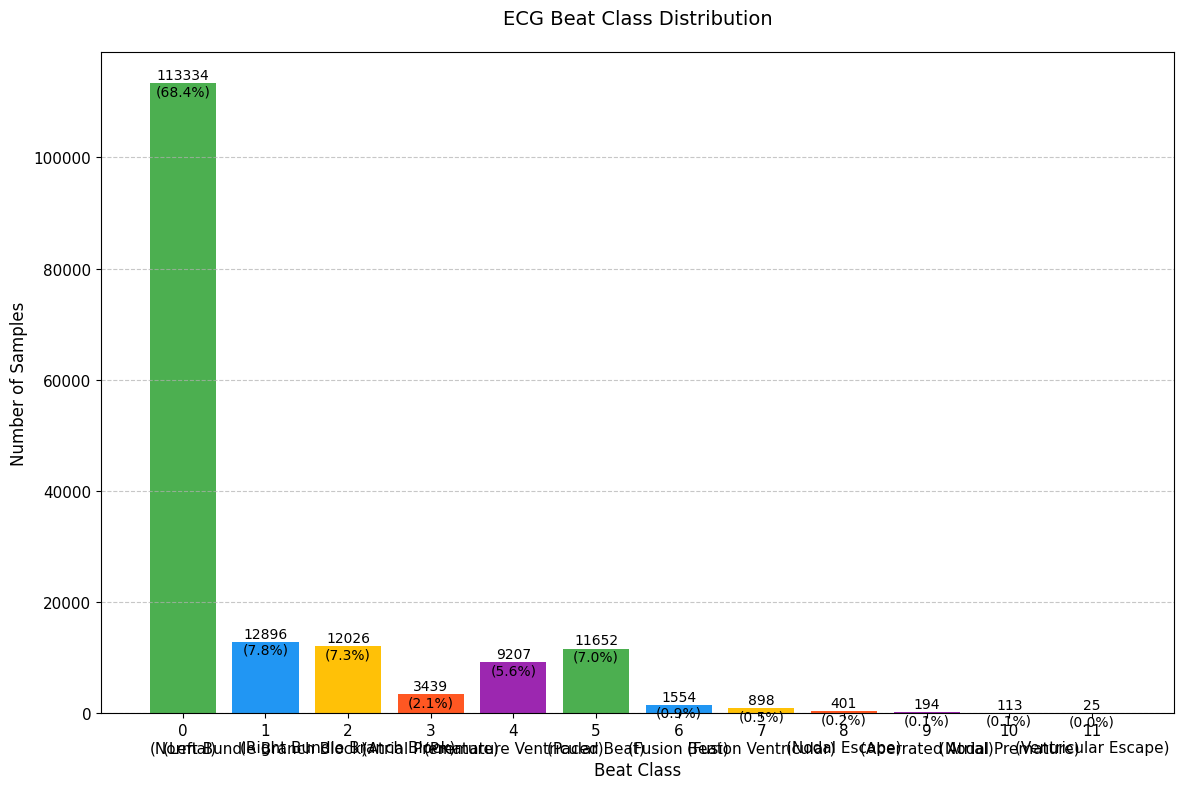

In [9]:
# %%
# Data Analysis
# Enhanced Dataset Analysis
print(f"\n{' Dataset Summary ':=^50}")
print(f"Final dataset shape: {X.shape}")
print(f"Total samples: {X.shape[0]}")
print(f"Number of features: {X.shape[1]}")

# Class distribution analysis
unique, counts = np.unique(y, return_counts=True)
total_samples = len(y)
class_percentages = counts / total_samples * 100

print("\nClass Distribution:")
print(f"{'Class':<10}{'Count':<10}{'Percentage':<12}{'Description':<20}")
for cls, count, perc in zip(unique, counts, class_percentages):
    print(f"{cls:<10}{count:<10}{perc:.1f}%{'':<8}{get_beat_description(cls)}")

# Enhanced Visualization
plt.figure(figsize=(12, 8))
bars = plt.bar([str(cls) for cls in unique], counts, 
               color=['#4CAF50', '#2196F3', '#FFC107', '#FF5722', '#9C27B0'])

# Add value labels and percentage on top of each bar
for bar in bars:
    height = bar.get_height()
    percentage = height/total_samples*100
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height}\n({percentage:.1f}%)',
             ha='center', va='center', fontsize=10)

plt.title("ECG Beat Class Distribution", fontsize=14, pad=20)
plt.xlabel("Beat Class", fontsize=12)
plt.ylabel("Number of Samples", fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add class descriptions to x-axis
ax = plt.gca()
ax.set_xticklabels([f"{cls}\n({get_beat_description(cls)})" for cls in unique])

plt.tight_layout()
plt.show()


In [10]:

# Class imbalance analysis
imbalance_ratio = max(counts)/min(counts)
print(f"\nClass Imbalance Ratio: {imbalance_ratio:.1f}:1")
print("Note: Consider using class weights or oversampling techniques" 
      if imbalance_ratio > 10 else "Class distribution is relatively balanced")



Class Imbalance Ratio: 4533.4:1
Note: Consider using class weights or oversampling techniques


In [11]:

# %%
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# %%


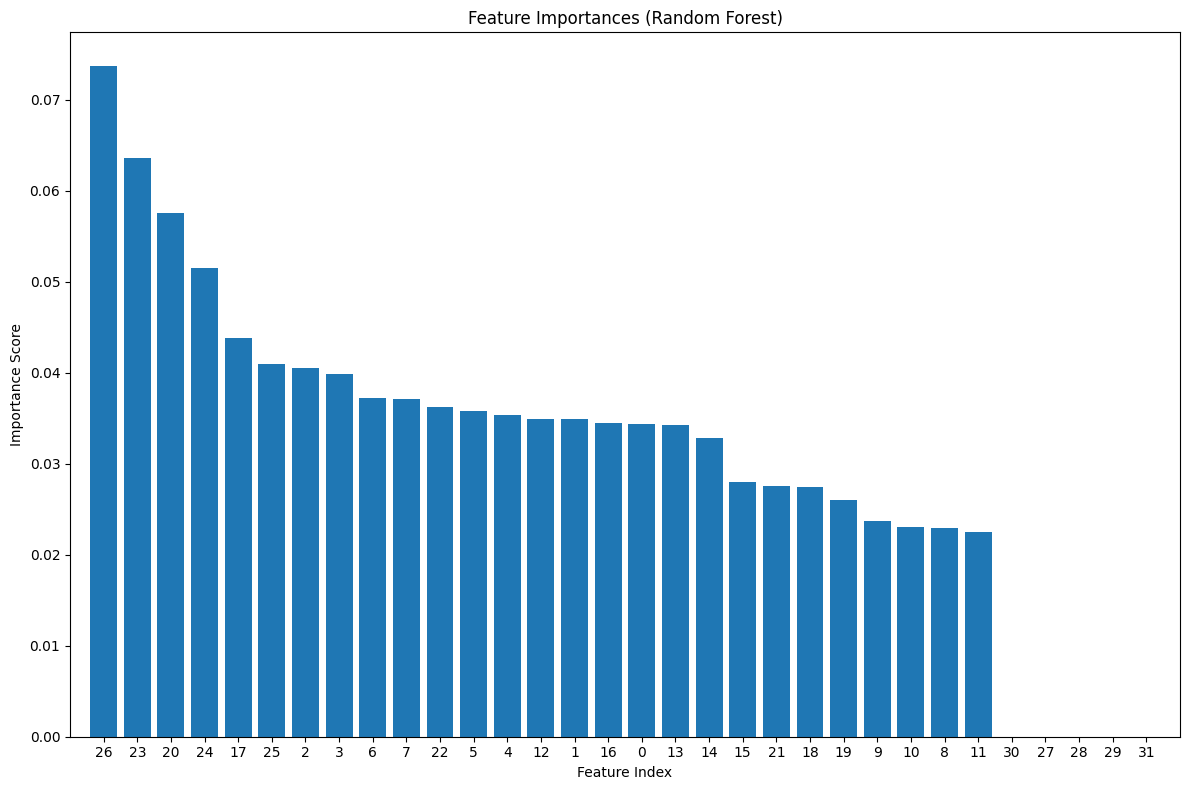


Top 20 Features:
1. Feature 26 - Importance: 0.0737
2. Feature 23 - Importance: 0.0635
3. Feature 20 - Importance: 0.0576
4. Feature 24 - Importance: 0.0515
5. Feature 17 - Importance: 0.0438
6. Feature 25 - Importance: 0.0409
7. Feature 2 - Importance: 0.0405
8. Feature 3 - Importance: 0.0399
9. Feature 6 - Importance: 0.0373
10. Feature 7 - Importance: 0.0371
11. Feature 22 - Importance: 0.0362
12. Feature 5 - Importance: 0.0358
13. Feature 4 - Importance: 0.0354
14. Feature 12 - Importance: 0.0349
15. Feature 1 - Importance: 0.0349
16. Feature 16 - Importance: 0.0345
17. Feature 0 - Importance: 0.0343
18. Feature 13 - Importance: 0.0343
19. Feature 14 - Importance: 0.0328
20. Feature 15 - Importance: 0.0280


In [ ]:
# Train initial model
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=30,
    min_samples_split=5,
    class_weight='balanced_subsample',  # Better for imbalanced data
    n_jobs=-1,
    random_state=42
)
rf.fit(X_train, y_train)

# Get feature importances
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot feature importance
plt.figure(figsize=(12, 8))
plt.title("Feature Importances (Random Forest)")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.xlabel("Feature Index")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()

# Print top N features
top_n = 20
print(f"\nTop {top_n} Features:")
for i in range(top_n):
    print(f"{i+1}. Feature {indices[i]} - Importance: {importances[indices[i]]:.4f}")

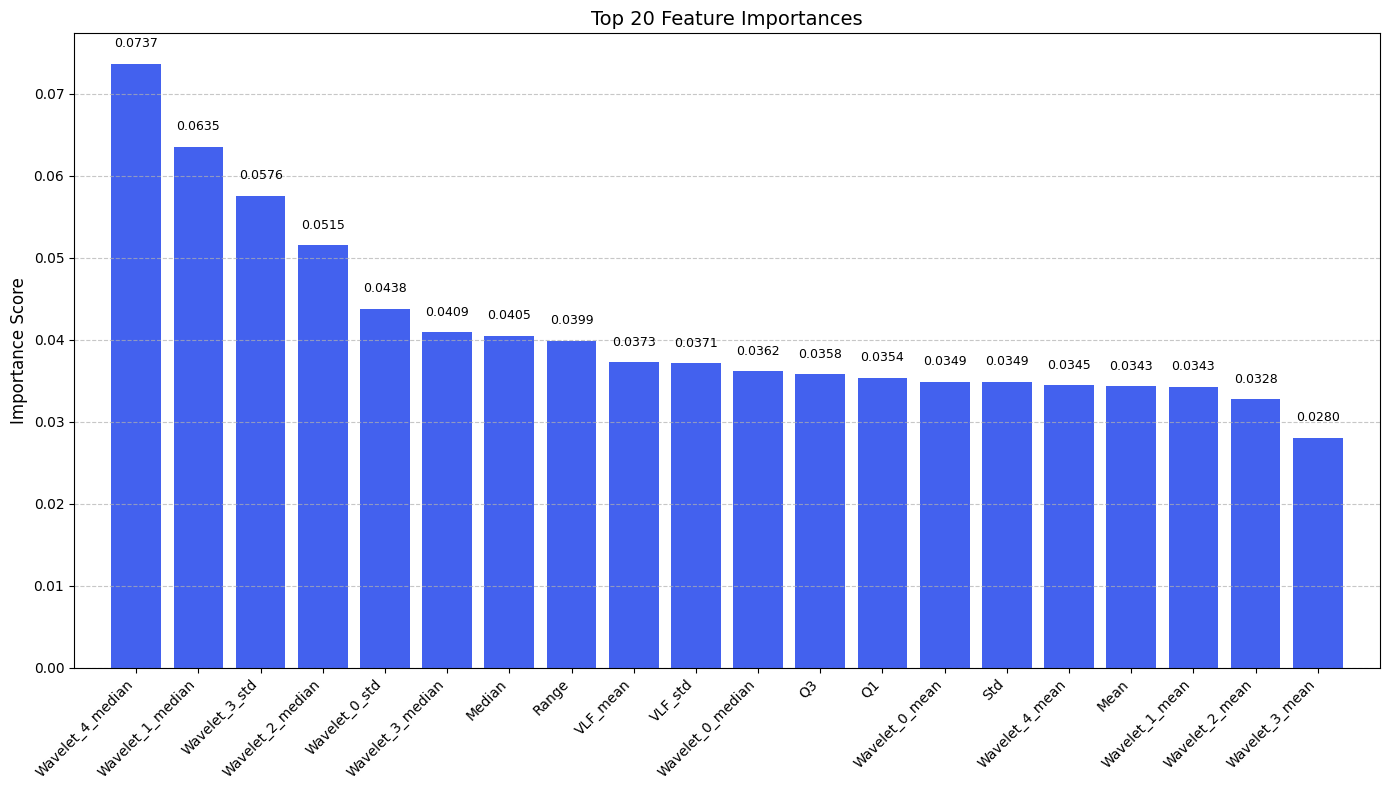


================= Top Feature Importances ==================
Rank  Feature                  Importance     Type                
------------------------------------------------------------
1     Wavelet_4_median         0.0737          Wavelet             
2     Wavelet_1_median         0.0635          Wavelet             
3     Wavelet_3_std            0.0576          Wavelet             
4     Wavelet_2_median         0.0515          Wavelet             
5     Wavelet_0_std            0.0438          Wavelet             
6     Wavelet_3_median         0.0409          Wavelet             
7     Median                   0.0405          Time-Domain         
8     Range                    0.0399          Time-Domain         
9     VLF_mean                 0.0373          Frequency-Domain    
10    VLF_std                  0.0371          Frequency-Domain    
11    Wavelet_0_median         0.0362          Wavelet             
12    Q3                       0.0358          Time-Domain    

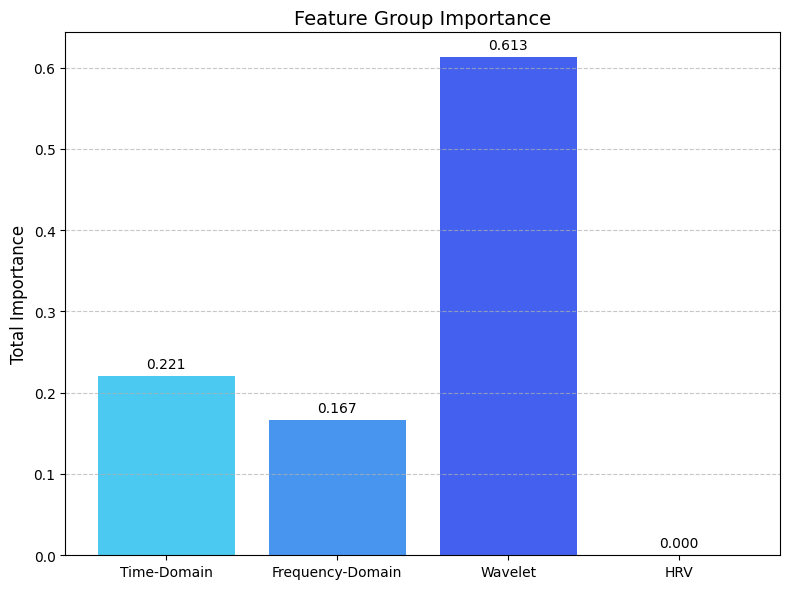

In [26]:
# Define feature names based on your extraction pipeline
feature_names = [
    # Time-domain features (6)
    'Mean', 'Std', 'Median', 'Range', 'Q1', 'Q3',
    
    # Frequency-domain features (6: 3 bands × 2 features each)
    'VLF_mean', 'VLF_std', 'LF_mean', 'LF_std', 'HF_mean', 'HF_std',
    
    # Wavelet features (15: 5 levels × 3 features each)
    *[f'Wavelet_{i}_mean' for i in range(5)],
    *[f'Wavelet_{i}_std' for i in range(5)],
    *[f'Wavelet_{i}_median' for i in range(5)],
    
    # HRV features (10)
    'HRV_MeanNN', 'HRV_SDNN', 'HRV_RMSSD', 'HRV_pNN50', 'HRV_MedianNN',
    'HRV_HTI', 'HRV_LF', 'HRV_HF', 'HRV_LFHF', 'HRV_TotalPower'
]

# Get feature importances
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot feature importance with names
plt.figure(figsize=(14, 8))
plt.title("Top 20 Feature Importances", fontsize=14)
plt.bar(range(20), importances[indices][:20], align="center", color='#4361ee')
plt.xticks(range(20), [feature_names[i] for i in indices[:20]], rotation=45, ha='right', fontsize=10)
plt.xlim([-1, 20])
plt.ylabel("Importance Score", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of bars
for i, v in enumerate(importances[indices][:20]):
    plt.text(i, v + 0.002, f"{v:.4f}", ha='center', fontsize=9)

plt.tight_layout()
plt.show()

# Print top N features with descriptions
top_n = 20
print(f"\n{' Top Feature Importances ':=^60}")
print(f"{'Rank':<6}{'Feature':<25}{'Importance':<15}{'Type':<20}")
print("-"*60)
for i in range(top_n):
    idx = indices[i]
    # Classify feature type
    if idx < 6:
        ftype = "Time-Domain"
    elif idx < 12:
        ftype = "Frequency-Domain"
    elif idx < 27:
        ftype = "Wavelet"
    else:
        ftype = "HRV"
    
    print(f"{i+1:<6}{feature_names[idx]:<25}{importances[idx]:.4f}{'':<10}{ftype:<20}")

# Add feature group importance
feature_groups = {
    'Time-Domain': sum(importances[:6]),
    'Frequency-Domain': sum(importances[6:12]),
    'Wavelet': sum(importances[12:27]),
    'HRV': sum(importances[27:])
}

plt.figure(figsize=(8, 6))
plt.title("Feature Group Importance", fontsize=14)
plt.bar(feature_groups.keys(), feature_groups.values(), color=['#4cc9f0', '#4895ef', '#4361ee', '#3f37c9'])
plt.ylabel("Total Importance", fontsize=12)
plt.xticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels
for i, (k, v) in enumerate(feature_groups.items()):
    plt.text(i, v + 0.01, f"{v:.3f}", ha='center', fontsize=10)

plt.tight_layout()
plt.show()

In [13]:
"""
# 4. Main processing loop (updated):
from tqdm import tqdm

all_features = []
all_labels = []

for record_id in tqdm(RECORD_IDS, desc="Processing records"):
    features, labels = process_record_safely(record_id)
    if features is not None and labels is not None:
        valid = labels != -1
        all_features.extend(features[valid])
        all_labels.extend(labels[valid])

X = np.array(all_features)
y = np.array(all_labels)"""



'\n# 4. Main processing loop (updated):\nfrom tqdm import tqdm\n\nall_features = []\nall_labels = []\n\nfor record_id in tqdm(RECORD_IDS, desc="Processing records"):\n    features, labels = process_record_safely(record_id)\n    if features is not None and labels is not None:\n        valid = labels != -1\n        all_features.extend(features[valid])\n        all_labels.extend(labels[valid])\n\nX = np.array(all_features)\ny = np.array(all_labels)'

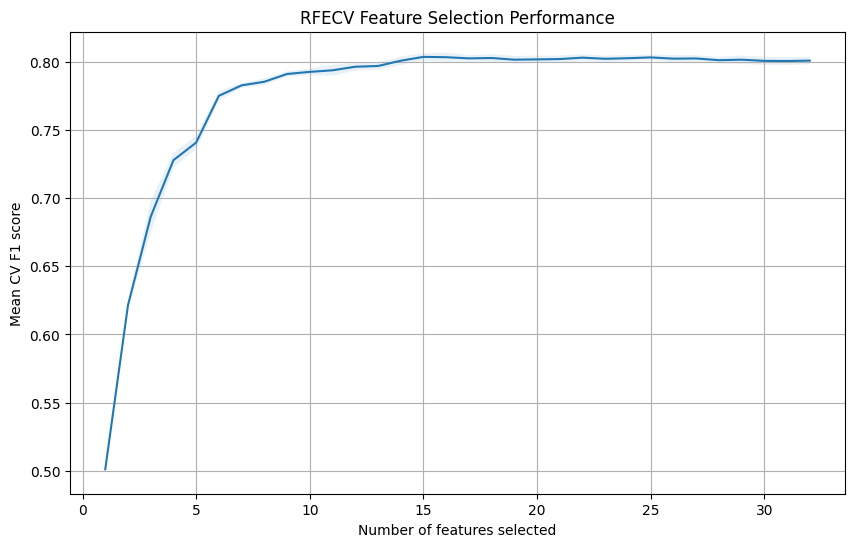

Optimal number of features: 15
Selected features: [ 2  3  4  5  6  7 12 15 17 20 22 23 24 25 26]


In [14]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

# Initialize RFE with cross-validation

selector = RFECV(rf, step=1, cv=StratifiedKFold(5), scoring='f1_weighted')

selector.fit(X_train, y_train)

"""# Plot number of features vs. CV scores (updated for scikit-learn >= 0.24)
plt.figure(figsize=(10, 6))
plt.xlabel("Number of features selected")
plt.ylabel("Mean CV F1 score")
plt.plot(
    range(1, len(selector.cv_results_["mean_test_score"]) + 1),
    selector.cv_results_["mean_test_score"]
)
plt.fill_between(
    range(1, len(selector.cv_results_["mean_test_score"]) + 1),
    selector.cv_results_["mean_test_score"] - selector.cv_results_["std_test_score"],
    selector.cv_results_["mean_test_score"] + selector.cv_results_["std_test_score"],
    alpha=0.1
)
plt.title("RFECV Feature Selection Performance")
plt.grid()
plt.show()

# Get optimal number of features
optimal_num_features = selector.n_features_
print(f"Optimal number of features: {optimal_num_features}")

# Get selected features mask
selected_features = selector.support_
print(f"Selected features: {np.where(selected_features)[0]}")"""

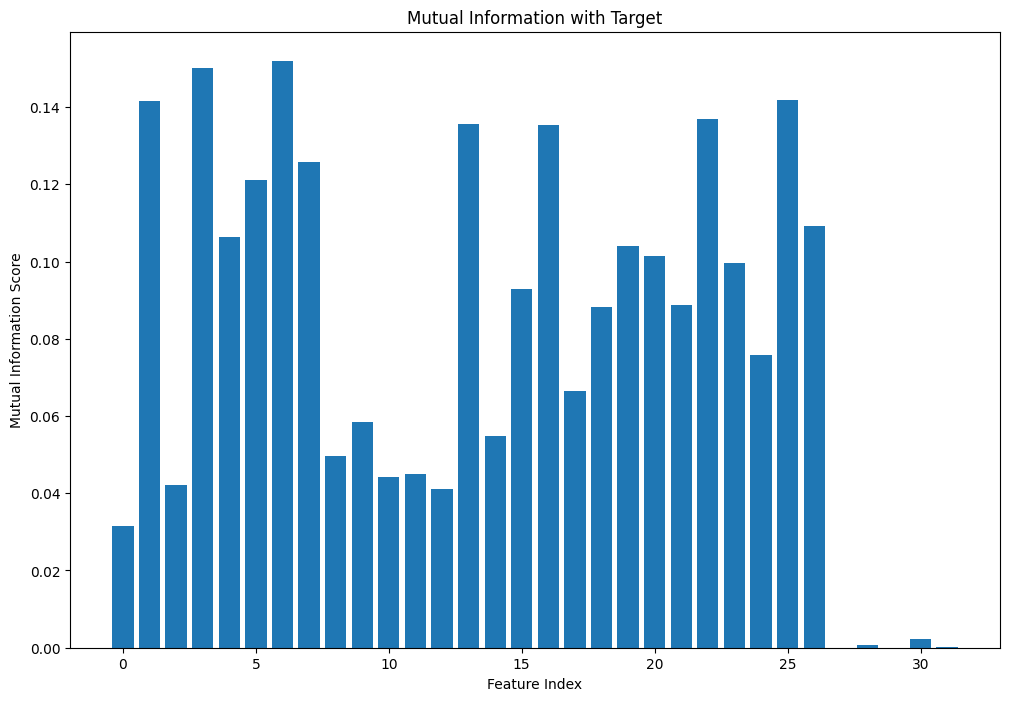


Top 15 Features by Mutual Information:
Feature 6: 0.1519
Feature 3: 0.1502
Feature 25: 0.1419
Feature 1: 0.1416
Feature 22: 0.1370
Feature 13: 0.1357
Feature 16: 0.1354
Feature 7: 0.1257
Feature 5: 0.1212
Feature 26: 0.1092
Feature 4: 0.1063
Feature 19: 0.1041
Feature 20: 0.1015
Feature 23: 0.0998
Feature 15: 0.0928


In [15]:
from sklearn.feature_selection import mutual_info_classif

# Calculate mutual information
mi = mutual_info_classif(X_train, y_train)

# Plot mutual information
plt.figure(figsize=(12, 8))
plt.bar(range(len(mi)), mi)
plt.title("Mutual Information with Target")
plt.xlabel("Feature Index")
plt.ylabel("Mutual Information Score")
plt.show()

# Select top K features based on MI
k = 15
top_k_indices = np.argsort(mi)[-k:][::-1]
print(f"\nTop {k} Features by Mutual Information:")
for idx in top_k_indices:
    print(f"Feature {idx}: {mi[idx]:.4f}")

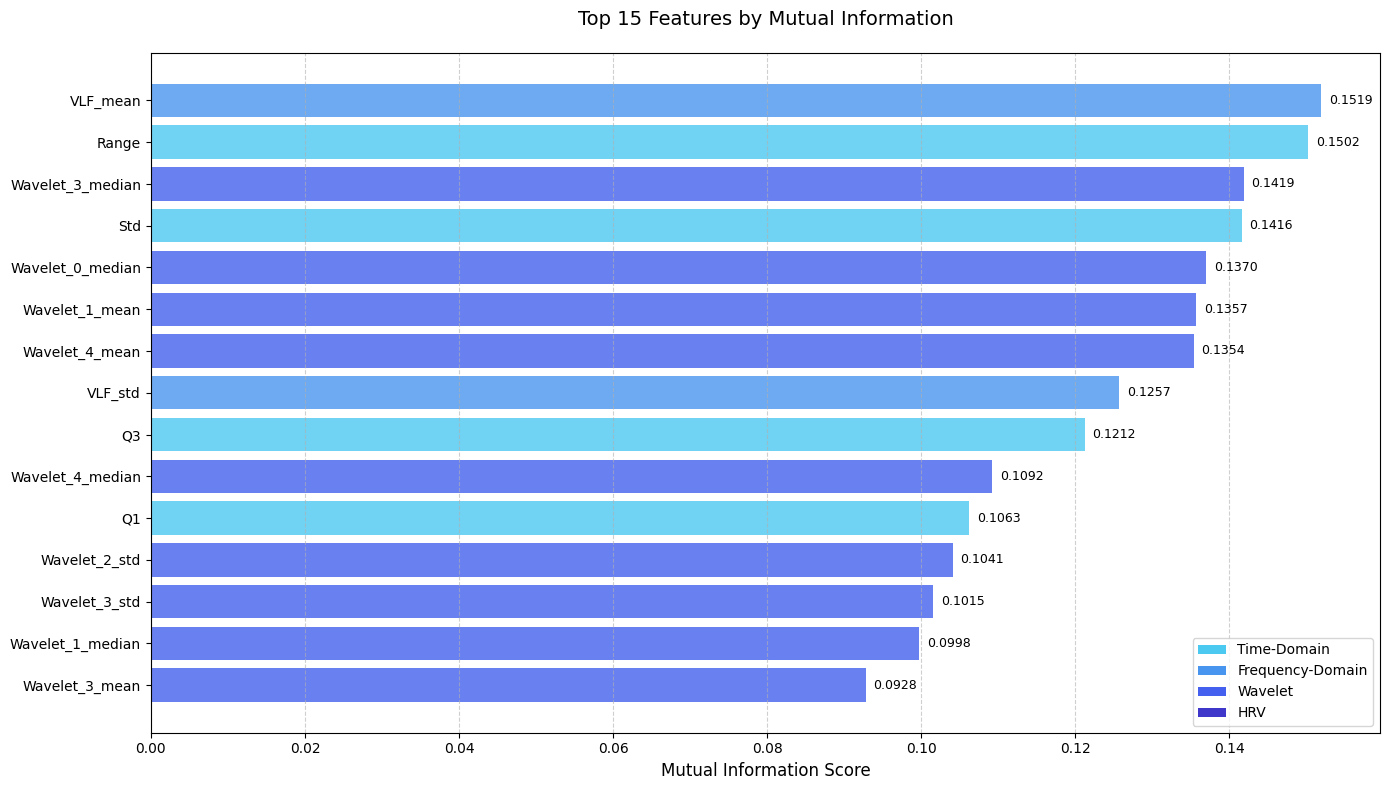


======================= Top Mutual Information Features ========================
Rank  Feature                  MI Score       Type                Importance Rank     
--------------------------------------------------------------------------------
1     VLF_mean                 0.1519          Frequency-Domain    27                  
2     Range                    0.1502          Time-Domain         3                   
3     Wavelet_3_median         0.1419          Wavelet             24                  
4     Std                      0.1416          Time-Domain         5                   
5     Wavelet_0_median         0.1370          Wavelet             9                   
6     Wavelet_1_mean           0.1357          Wavelet             11                  
7     Wavelet_4_mean           0.1354          Wavelet             13                  
8     VLF_std                  0.1257          Frequency-Domain    29                  
9     Q3                       0.1212         

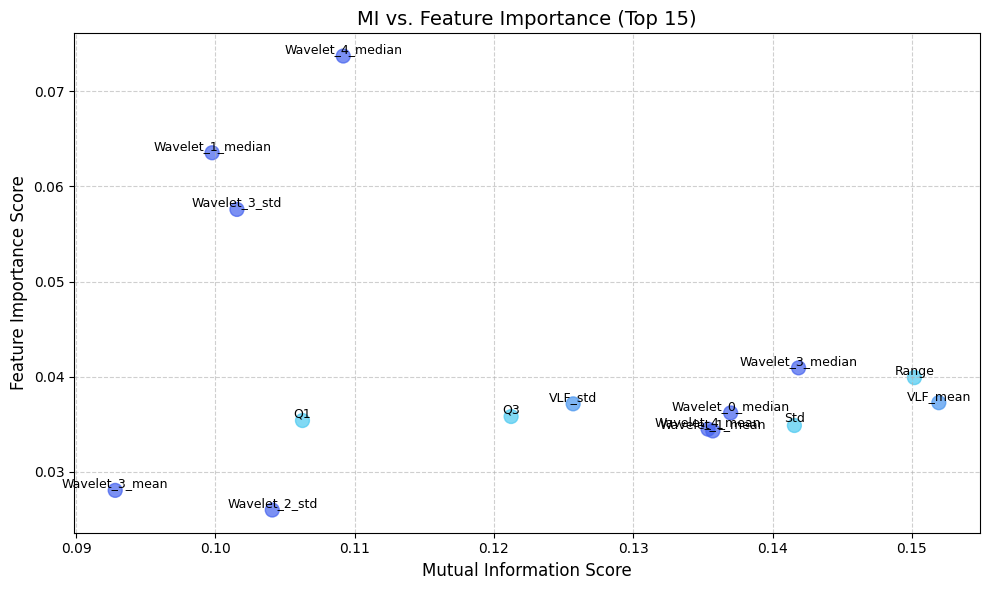

In [27]:
# Define feature names (consistent with previous implementation)
feature_names = [
    # Time-domain features (6)
    'Mean', 'Std', 'Median', 'Range', 'Q1', 'Q3',
    
    # Frequency-domain features (6: 3 bands × 2 features each)
    'VLF_mean', 'VLF_std', 'LF_mean', 'LF_std', 'HF_mean', 'HF_std',
    
    # Wavelet features (15: 5 levels × 3 features each)
    *[f'Wavelet_{i}_mean' for i in range(5)],
    *[f'Wavelet_{i}_std' for i in range(5)],
    *[f'Wavelet_{i}_median' for i in range(5)],
    
    # HRV features (10)
    'HRV_MeanNN', 'HRV_SDNN', 'HRV_RMSSD', 'HRV_pNN50', 'HRV_MedianNN',
    'HRV_HTI', 'HRV_LF', 'HRV_HF', 'HRV_LFHF', 'HRV_TotalPower'
]

# Plot top mutual information features
plt.figure(figsize=(14, 8))
plt.title("Top 15 Features by Mutual Information", fontsize=14, pad=20)

# Get top k features
k = 15
top_k_indices = np.argsort(mi)[-k:][::-1]
top_k_names = [feature_names[i] for i in top_k_indices]
top_k_mi = mi[top_k_indices]

# Create colored bars by feature type
colors = []
for idx in top_k_indices:
    if idx < 6:
        colors.append('#4cc9f0')  # Time-domain (blue)
    elif idx < 12:
        colors.append('#4895ef')  # Frequency-domain (light blue)
    elif idx < 27:
        colors.append('#4361ee')  # Wavelet (primary blue)
    else:
        colors.append('#3f37c9')  # HRV (dark blue)

bars = plt.barh(range(k), top_k_mi, color=colors, alpha=0.8)
plt.yticks(range(k), top_k_names, fontsize=10)
plt.xlabel("Mutual Information Score", fontsize=12)
plt.gca().invert_yaxis()  # Highest MI at top
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Add value labels
for i, v in enumerate(top_k_mi):
    plt.text(v + 0.001, i, f"{v:.4f}", va='center', fontsize=9)

# Create legend for feature types
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#4cc9f0', label='Time-Domain'),
    Patch(facecolor='#4895ef', label='Frequency-Domain'),
    Patch(facecolor='#4361ee', label='Wavelet'),
    Patch(facecolor='#3f37c9', label='HRV')
]
plt.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.show()

# Print detailed table
print(f"\n{' Top Mutual Information Features ':=^80}")
print(f"{'Rank':<6}{'Feature':<25}{'MI Score':<15}{'Type':<20}{'Importance Rank':<20}")
print("-"*80)

# Get importance ranks for comparison
importance_ranks = np.argsort(np.argsort(importances))[::-1]  # Convert to ranks (1=highest)

for i, idx in enumerate(top_k_indices, 1):
    # Classify feature type
    if idx < 6:
        ftype = "Time-Domain"
    elif idx < 12:
        ftype = "Frequency-Domain"
    elif idx < 27:
        ftype = "Wavelet"
    else:
        ftype = "HRV"
    
    print(f"{i:<6}{feature_names[idx]:<25}{mi[idx]:.4f}{'':<10}{ftype:<20}{importance_ranks[idx]+1:<20}")

# Compare with feature importance
plt.figure(figsize=(10, 6))
plt.title("MI vs. Feature Importance (Top 15)", fontsize=14)
plt.scatter(mi[top_k_indices], importances[top_k_indices], c=colors, s=100, alpha=0.7)

# Add labels
for i, idx in enumerate(top_k_indices):
    plt.text(mi[idx], importances[idx], feature_names[idx], fontsize=9, 
             ha='center', va='bottom')

plt.xlabel("Mutual Information Score", fontsize=12)
plt.ylabel("Feature Importance Score", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

c:\Users\mhame\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\mhame\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


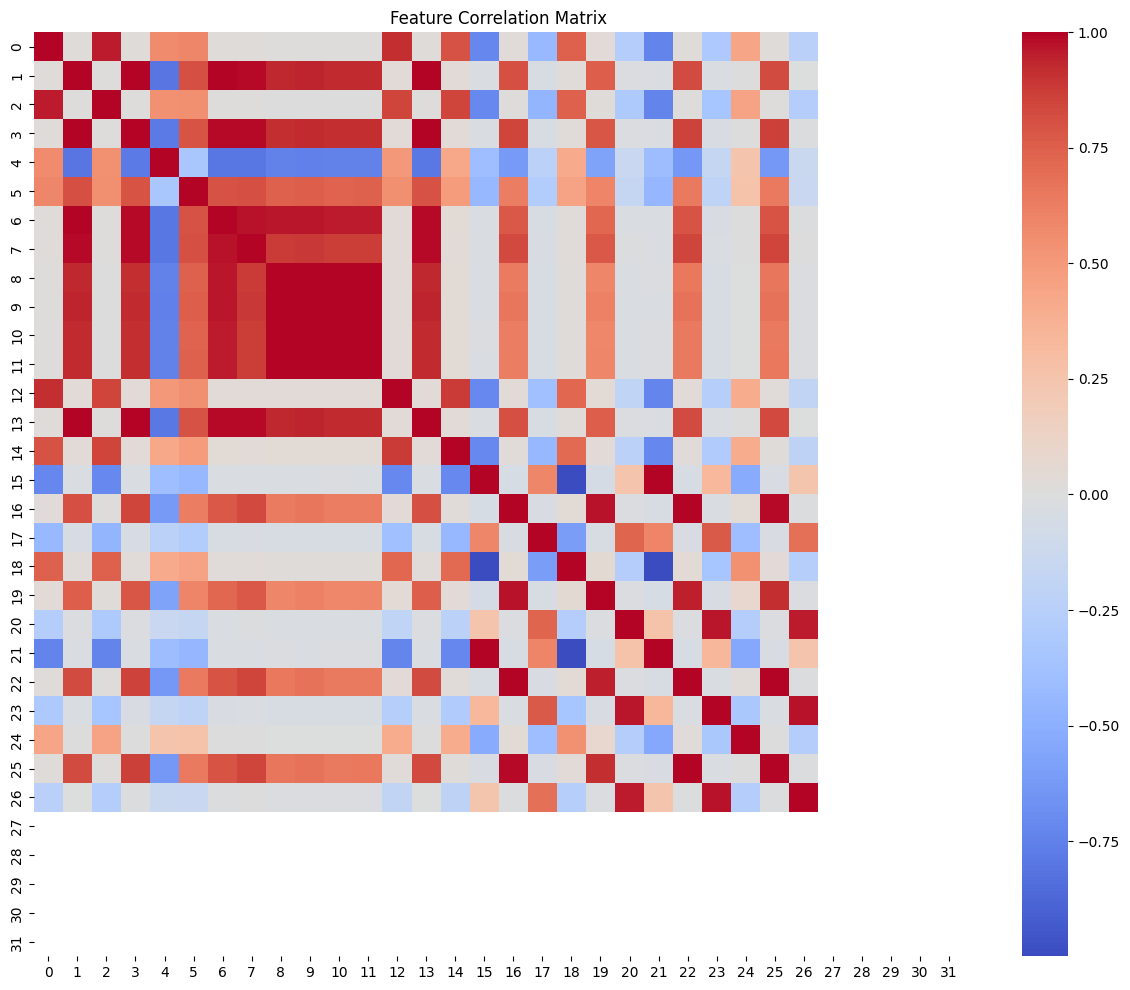


Number of highly correlated features (|r| > 0.85): 17
Indices of highly correlated features: {0, 1, 3, 6, 7, 8, 9, 10, 11, 12, 15, 16, 18, 19, 20, 22, 23}


In [16]:
# Calculate correlation matrix
corr_matrix = np.corrcoef(X_train, rowvar=False)

# Plot correlation heatmap
plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
plt.title("Feature Correlation Matrix")
plt.show()

# Identify highly correlated features
threshold = 0.85
highly_correlated = set()
for i in range(len(corr_matrix)):
    for j in range(i):
        if abs(corr_matrix[i, j]) > threshold:
            highly_correlated.add(j)
            
print(f"\nNumber of highly correlated features (|r| > {threshold}): {len(highly_correlated)}")
print("Indices of highly correlated features:", highly_correlated)

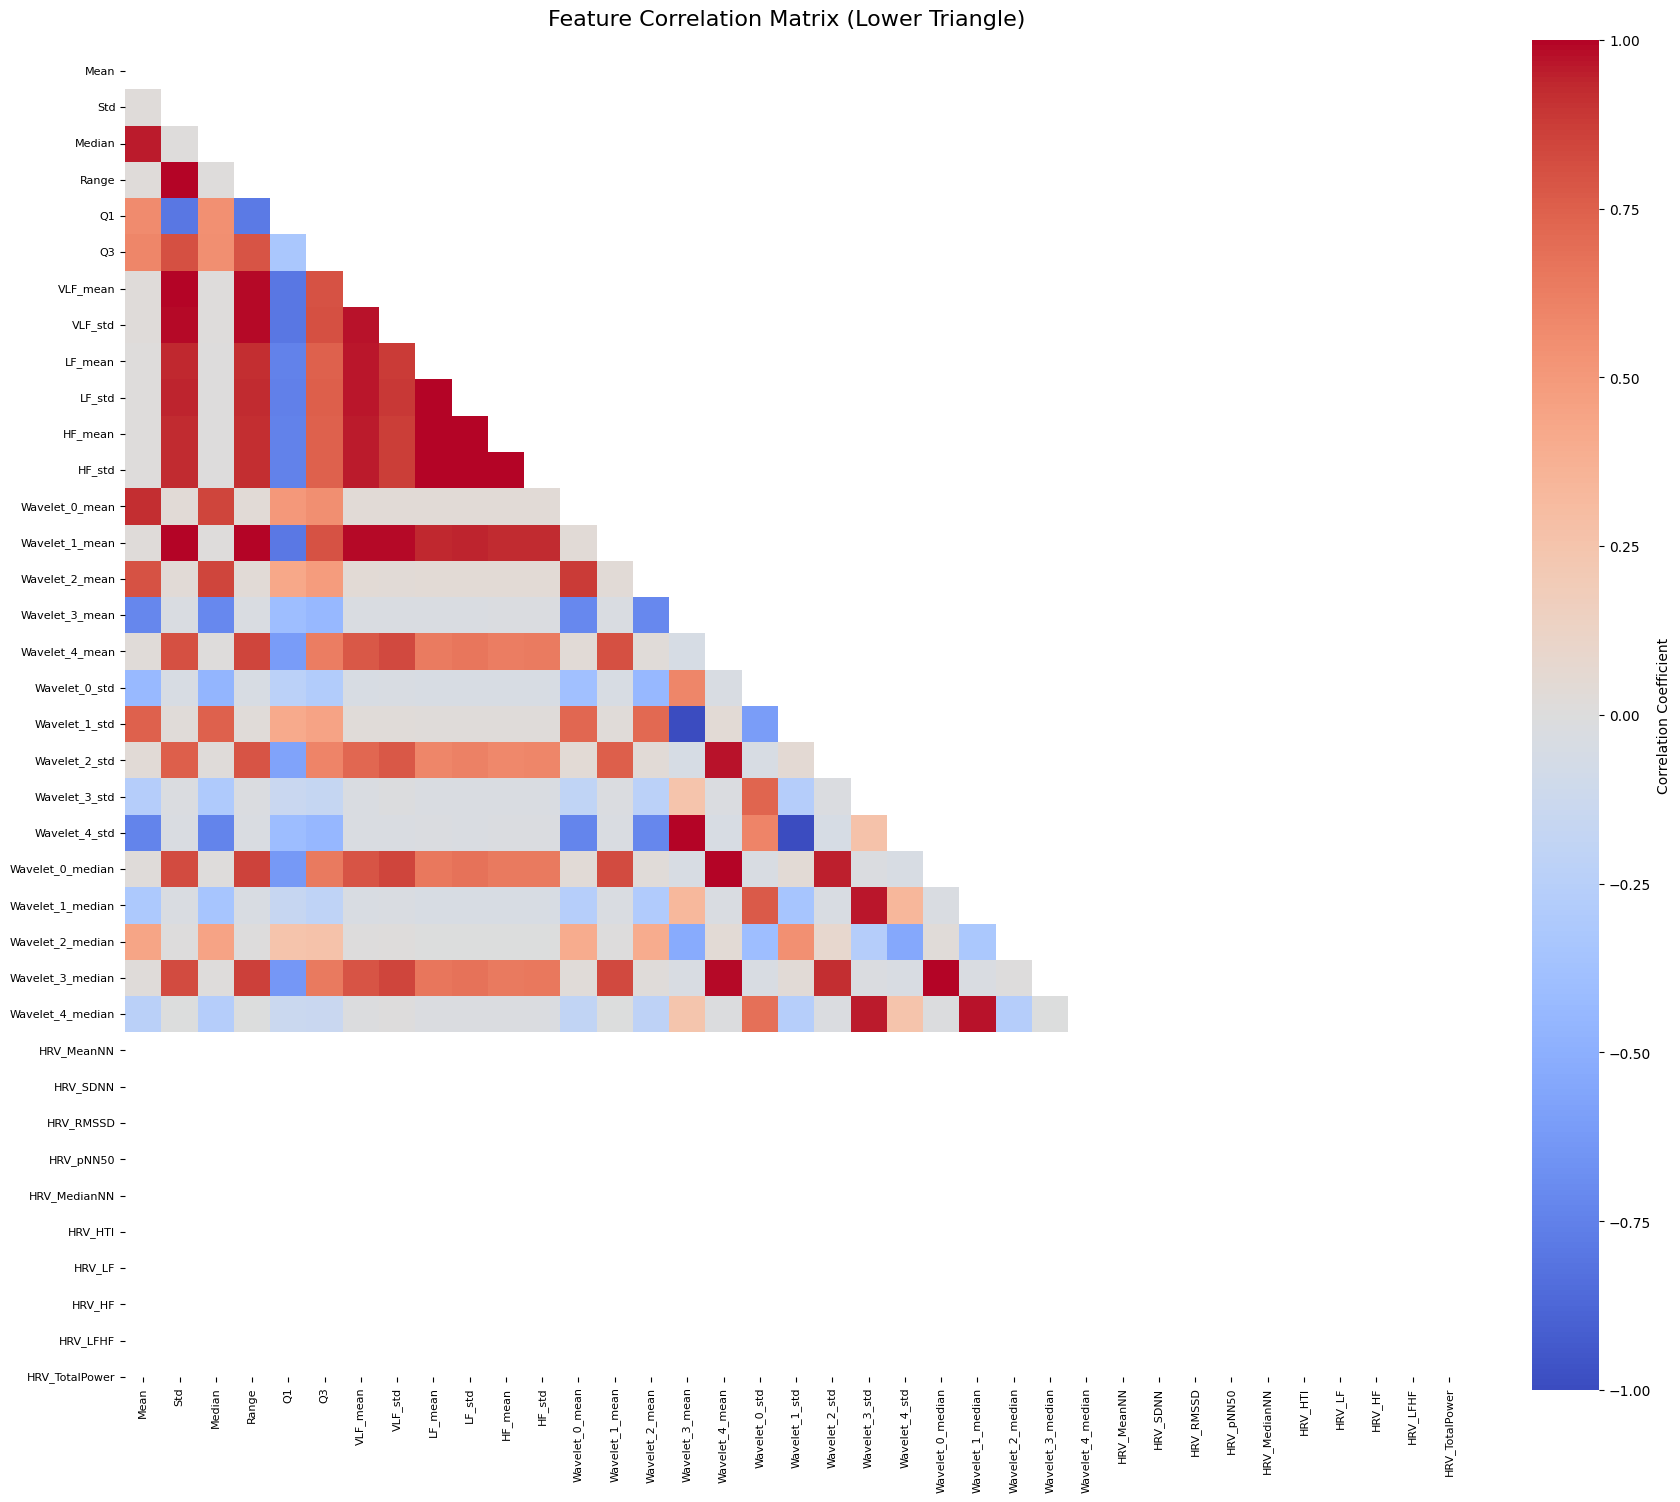


======================= Highly Correlated Feature Pairs ========================
Feature A                     Feature B                     Correlation    Type A              Type B              
--------------------------------------------------------------------------------
HF_std                        HF_mean                       1.0000          Frequency-Domain    Frequency-Domain    
HF_std                        LF_mean                       0.9999          Frequency-Domain    Frequency-Domain    
HF_mean                       LF_mean                       0.9998          Frequency-Domain    Frequency-Domain    
LF_std                        LF_mean                       0.9994          Frequency-Domain    Frequency-Domain    
Wavelet_4_std                 Wavelet_1_std                 -0.9992          Wavelet             Wavelet             
HF_std                        LF_std                        0.9990          Frequency-Domain    Frequency-Domain    
Wavelet_4_std     

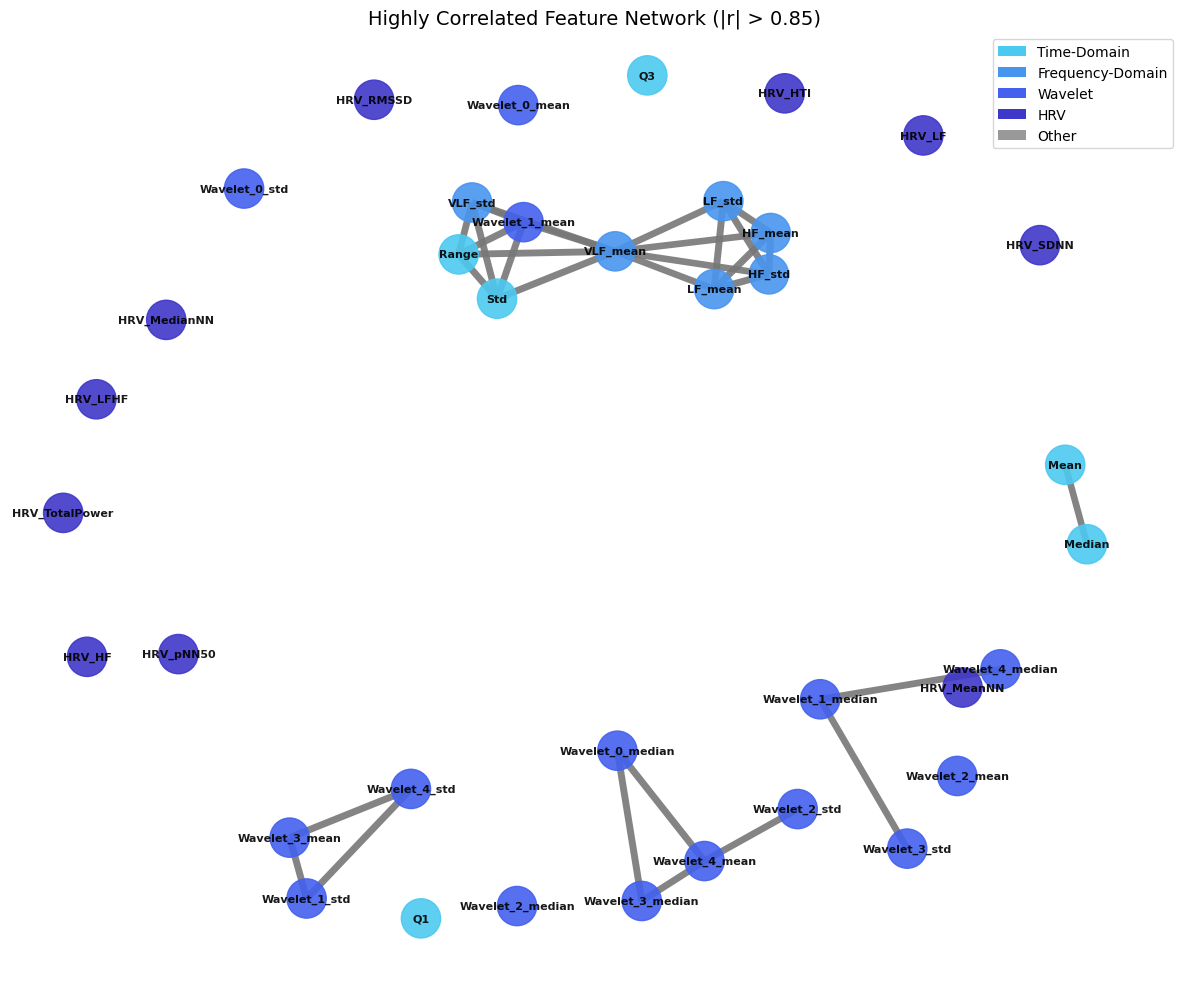

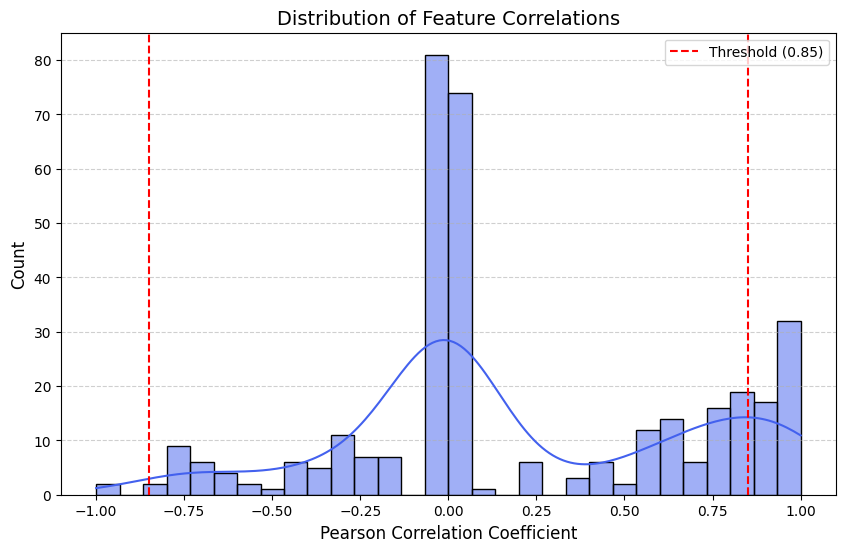

In [30]:

import networkx as nx 
# Enhanced Correlation Analysis with Feature Names
plt.figure(figsize=(18, 15))

# Create mask for upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Plot heatmap with feature names
sns.heatmap(corr_matrix, 
            mask=mask,
            cmap='coolwarm', 
            center=0,
            vmin=-1, vmax=1,
            xticklabels=feature_names,
            yticklabels=feature_names,
            cbar_kws={'label': 'Correlation Coefficient'},
            annot=False,  # Disable annotations for cleaner view
            square=True)

plt.title("Feature Correlation Matrix (Lower Triangle)", fontsize=16, pad=20)
plt.xticks(rotation=90, ha='center', fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()

# Enhanced highly correlated feature analysis
threshold = 0.85
highly_correlated_pairs = []

for i in range(len(corr_matrix)):
    for j in range(i):
        if abs(corr_matrix[i, j]) > threshold:
            highly_correlated_pairs.append((
                feature_names[i], 
                feature_names[j], 
                corr_matrix[i, j]
            ))

# Sort by absolute correlation
highly_correlated_pairs.sort(key=lambda x: abs(x[2]), reverse=True)

print(f"\n{' Highly Correlated Feature Pairs ':=^80}")
print(f"{'Feature A':<30}{'Feature B':<30}{'Correlation':<15}{'Type A':<20}{'Type B':<20}")
print("-"*80)

for pair in highly_correlated_pairs[:20]:  # Show top 20 pairs
    # Get feature types
    def get_feature_type(name):
        if name.startswith('Wavelet'): return 'Wavelet'
        if name.startswith('HRV'): return 'HRV'
        if name in ['Mean','Std','Median','Range','Q1','Q3']: return 'Time-Domain'
        if any(x in name for x in ['VLF','LF','HF']): return 'Frequency-Domain'
        return 'Other'
    
    print(f"{pair[0]:<30}{pair[1]:<30}{pair[2]:.4f}{'':<10}{get_feature_type(pair[0]):<20}{get_feature_type(pair[1]):<20}")

# Plot network of high correlations
plt.figure(figsize=(12, 10))
G = nx.Graph()

# Add nodes with type attributes
for name in feature_names:
    G.add_node(name, type=get_feature_type(name))

# Add edges for high correlations
for pair in highly_correlated_pairs[:30]:  # Limit to top 30 for readability
    G.add_edge(pair[0], pair[1], weight=abs(pair[2]))

# Color nodes by type
color_map = {
    'Time-Domain': '#4cc9f0',
    'Frequency-Domain': '#4895ef',
    'Wavelet': '#4361ee', 
    'HRV': '#3f37c9',
    'Other': '#999999'
}
colors = [color_map[G.nodes[n]['type']] for n in G.nodes()]

# Draw network
pos = nx.spring_layout(G, k=0.5, iterations=50)
weights = [G[u][v]['weight']*5 for u,v in G.edges()]

nx.draw_networkx(G, pos, 
                 node_color=colors,
                 node_size=800,
                 width=weights,
                 edge_color='#777777',
                 alpha=0.9,
                 font_size=8,
                 font_weight='bold')

plt.title("Highly Correlated Feature Network (|r| > 0.85)", fontsize=14)
plt.axis('off')

# Create legend
legend_elements = [Patch(facecolor=v, label=k) for k,v in color_map.items()]
plt.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()

# Correlation distribution plot
plt.figure(figsize=(10, 6))
sns.histplot(corr_matrix[np.triu_indices_from(corr_matrix, k=1)].flatten(),
             bins=30,
             kde=True,
             color='#4361ee')
plt.title("Distribution of Feature Correlations", fontsize=14)
plt.xlabel("Pearson Correlation Coefficient", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.axvline(x=threshold, color='r', linestyle='--', label=f'Threshold ({threshold})')
plt.axvline(x=-threshold, color='r', linestyle='--')
plt.legend()
plt.show()

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel

# Define the pipeline (combines scaler + feature selection + classifier)
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', SelectFromModel(
        RandomForestClassifier(n_estimators=100, random_state=42),
        threshold="median"
    )),
    ('classifier', RandomForestClassifier(
        n_estimators=200,
        max_depth=30,
        min_samples_split=5,
        class_weight='balanced_subsample',
        n_jobs=-1,
        random_state=42
    ))
])

# Train the pipeline (automatically handles scaling + feature selection)
print("Training model with full pipeline...")
pipeline.fit(X_train, y_train)

# Save the ENTIRE pipeline (no need to save scaler/selector separately)
joblib.dump(pipeline, 'ecg_pipeline.pkl')
print("Pipeline saved successfully.")





# Get selected features
selected_mask = pipeline.named_steps['feature_selection'].get_support()
selected_features = np.where(selected_mask)[0]
print(f"\nSelected {len(selected_features)} features:")
print(selected_features)

# Evaluate performance
print("\nPipeline Classification Report:")
print(classification_report(y_test, pipeline.predict(X_test)))

Training model with full pipeline...
Pipeline saved successfully.

Selected 16 features:
[ 0  1  2  3  5  6  7 13 16 17 20 22 23 24 25 26]

Pipeline Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.95      0.89     22667
           1       0.82      0.65      0.72      2579
           2       0.69      0.52      0.59      2405
           3       0.77      0.10      0.18       688
           4       0.69      0.42      0.52      1841
           5       0.84      0.75      0.79      2330
           6       0.64      0.02      0.04       311
           7       0.60      0.23      0.34       180
           8       0.06      0.01      0.02        80
           9       0.00      0.00      0.00        39
          10       0.00      0.00      0.00        23
          11       0.00      0.00      0.00         5

    accuracy                           0.82     33148
   macro avg       0.49      0.30      0.34     33148
weighted avg    

c:\Users\mhame\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mhame\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mhame\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

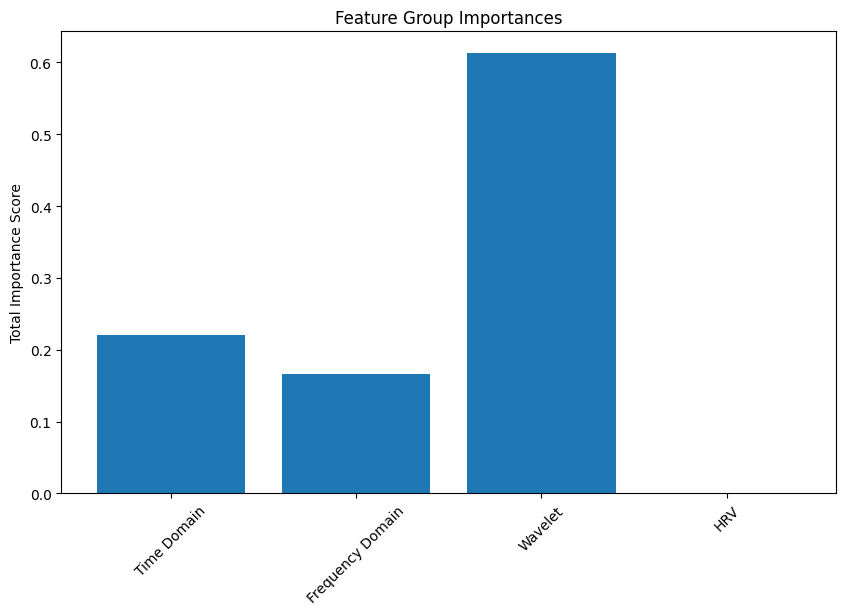

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Get feature importances safely
importances = rf.feature_importances_
n_features = len(importances)

# 2. Define feature groups with bounds checking
feature_groups = {
    'Time Domain': range(0, min(6, n_features)),
    'Frequency Domain': range(6, min(12, n_features)),
    'Wavelet': range(12, min(27, n_features)),
    'HRV': range(27, min(37, n_features)),
    'Other': range(37, n_features)
}

# 3. Calculate group importances with validation
group_importances = {}
for group_name, indices in feature_groups.items():
    valid_indices = [i for i in indices if i < n_features]
    if valid_indices:  # Only process if indices exist
        group_importances[group_name] = np.sum(importances[valid_indices])

# 4. Plot with error handling
if group_importances:
    plt.figure(figsize=(10, 6))
    plt.bar(group_importances.keys(), group_importances.values())
    plt.title("Feature Group Importances")
    plt.ylabel("Total Importance Score")
    plt.xticks(rotation=45)
    plt.show()
else:
    print("No valid feature groups found. Check your feature indices.")

In [19]:
"""# Model Training - Enhanced Random Forest
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=30,
    min_samples_split=5,
    class_weight='balanced_subsample',  # Better for imbalanced data
    n_jobs=-1,
    random_state=42
)

print("Training model...")
rf.fit(X_train, y_train)"""



'# Model Training - Enhanced Random Forest\nrf = RandomForestClassifier(\n    n_estimators=200,\n    max_depth=30,\n    min_samples_split=5,\n    class_weight=\'balanced_subsample\',  # Better for imbalanced data\n    n_jobs=-1,\n    random_state=42\n)\n\nprint("Training model...")\nrf.fit(X_train, y_train)'

Training Set Evaluation:

              precision    recall  f1-score   support

           N       1.00      1.00      1.00     90667
           L       0.99      1.00      1.00     10317
           R       1.00      1.00      1.00      9621
           A       1.00      1.00      1.00      2751
           V       1.00      1.00      1.00      7366
           /       0.99      1.00      1.00      9322
           f       1.00      1.00      1.00      1243
           F       1.00      1.00      1.00       718
           j       0.98      1.00      0.99       321
           a       1.00      1.00      1.00       155
           J       1.00      1.00      1.00        90
           e       1.00      1.00      1.00        20

    accuracy                           1.00    132591
   macro avg       1.00      1.00      1.00    132591
weighted avg       1.00      1.00      1.00    132591



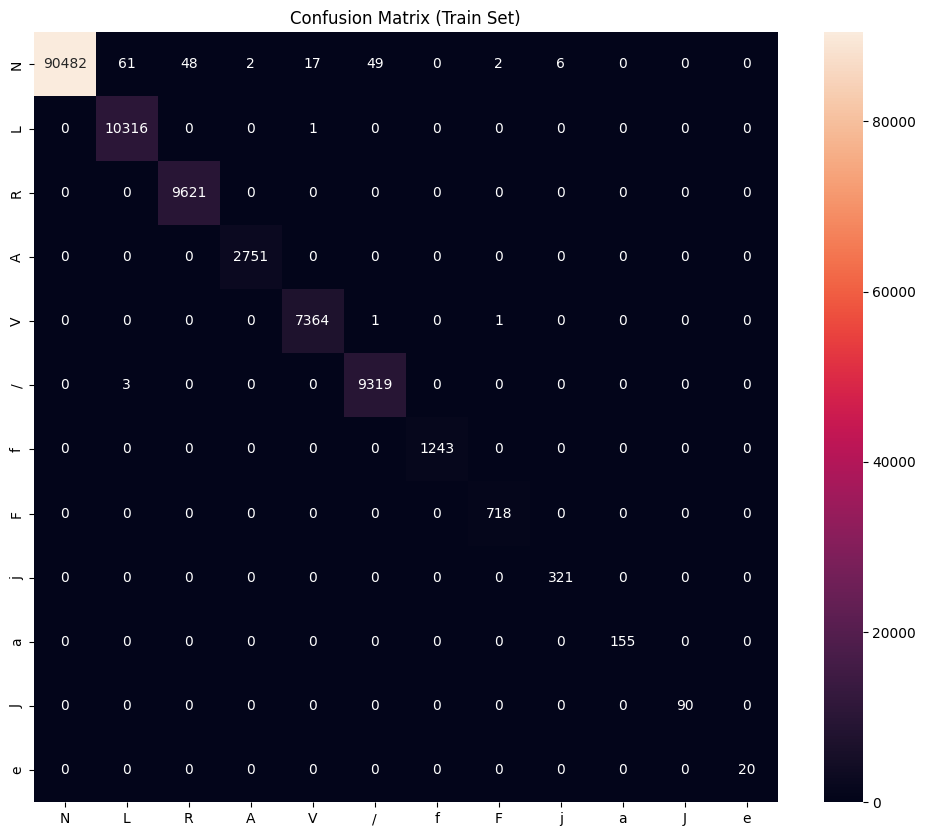


Test Set Evaluation:


c:\Users\mhame\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mhame\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mhame\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo


              precision    recall  f1-score   support

           N       0.84      0.96      0.90     22667
           L       0.84      0.65      0.74      2579
           R       0.73      0.50      0.60      2405
           A       0.83      0.08      0.15       688
           V       0.72      0.43      0.54      1841
           /       0.87      0.77      0.81      2330
           f       0.83      0.03      0.06       311
           F       0.63      0.28      0.39       180
           j       0.13      0.03      0.04        80
           a       0.00      0.00      0.00        39
           J       0.00      0.00      0.00        23
           e       0.00      0.00      0.00         5

    accuracy                           0.83     33148
   macro avg       0.53      0.31      0.35     33148
weighted avg       0.82      0.83      0.81     33148



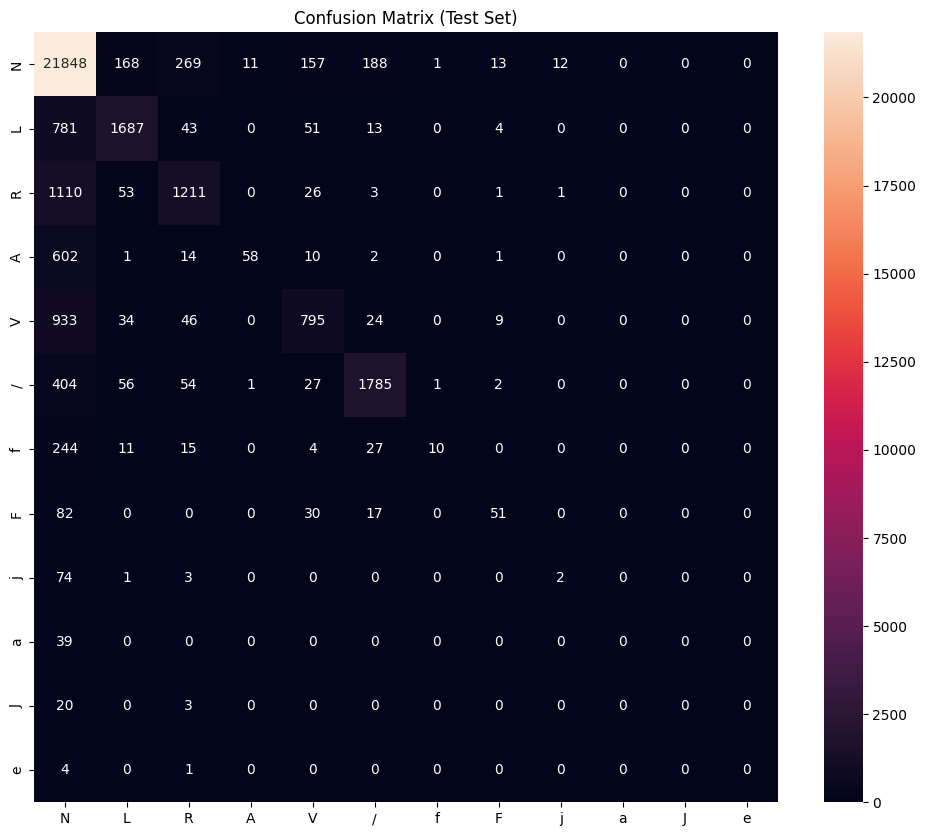

In [20]:
# %%
# Evaluation
def evaluate_model(model, X, y, set_name="Test"):
    y_pred = model.predict(X)
    
    print(f"\n{classification_report(y, y_pred, target_names=list(LABEL_MAPPING.keys()))}")
    
    # Confusion matrix
    plt.figure(figsize=(12, 10))
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', 
                xticklabels=LABEL_MAPPING.keys(), 
                yticklabels=LABEL_MAPPING.keys())
    plt.title(f"Confusion Matrix ({set_name} Set)")
    plt.show()

print("Training Set Evaluation:")
evaluate_model(rf, X_train, y_train, "Train")

print("\nTest Set Evaluation:")
evaluate_model(rf, X_test, y_test, "Test")



In [21]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import json
import numpy as np
from collections import defaultdict

# Calculate basic metrics
y_pred = rf.predict(X_test)
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)

# Handle ROC AUC carefully for multi-class
roc_auc_scores = {}
try:
    y_proba = rf.predict_proba(X_test)
    if len(np.unique(y_test)) > 2:  # Multiclass case
        roc_auc_scores = {str(i): float(v) for i, v in 
                         enumerate(roc_auc_score(y_test, y_proba, average=None, multi_class='ovr'))}
    else:  # Binary case
        roc_auc_scores = {'0': float(roc_auc_score(y_test, y_proba[:, 1]))}
except Exception as e:
    print(f"ROC AUC calculation warning: {str(e)}")
    roc_auc_scores = {str(i): 0.0 for i in range(len(np.unique(y_test)))}

# Get feature importance with names if available
try:
    feature_importances = {f"feature_{i}": float(v) 
                         for i, v in enumerate(rf.feature_importances_)}
except AttributeError:
    feature_importances = {"feature_importances": "not_available"}

# Build comprehensive metrics
metrics = {
    "class_metrics": {
        str(cls): {
            "precision": float(precision[i]),
            "recall": float(recall[i]),
            "f1": float(f1[i]),
            "roc_auc": float(roc_auc_scores.get(str(i), 0.0))
        }
        for i, cls in enumerate(np.unique(y_test))
    },
    "overall_metrics": {
        "precision_weighted": float(precision_score(y_test, y_pred, average='weighted')),
        "recall_weighted": float(recall_score(y_test, y_pred, average='weighted')),
        "f1_weighted": float(f1_score(y_test, y_pred, average='weighted')),
        "accuracy": float(np.mean(y_pred == y_test))
    },
    "metadata": {
        "training_samples": int(X_train.shape[0]),
        "test_samples": int(X_test.shape[0]),
        "num_features": int(X_train.shape[1]),
        "classes": [str(cls) for cls in np.unique(y_test)]
    },
    "feature_importances": feature_importances
}

# Save with pretty formatting
with open('model_metrics.json', 'w') as f:
    json.dump(metrics, f, indent=4, sort_keys=True)

print("Successfully saved metrics to model_metrics.json")

c:\Users\mhame\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Successfully saved metrics to model_metrics.json


c:\Users\mhame\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [31]:
# %%
# Save Model and Scaler
joblib.dump(rf, 'enhanced_ecg_classifier02.pkl')
joblib.dump(scaler, 'ecg_scaler02.pkl')
print("Model and scaler saved successfully.")



Model and scaler saved successfully.


In [23]:
# %%
"""# Feature Importance Analysis
importances = rf.feature_importances_
top_indices = np.argsort(importances)[-20:]  # Top 20 features

plt.figure(figsize=(10, 8))
plt.barh(range(20), importances[top_indices])
plt.yticks(range(20), [f"Feature {i}" for i in top_indices])
plt.title("Top 20 Important Features")
plt.show()"""

'# Feature Importance Analysis\nimportances = rf.feature_importances_\ntop_indices = np.argsort(importances)[-20:]  # Top 20 features\n\nplt.figure(figsize=(10, 8))\nplt.barh(range(20), importances[top_indices])\nplt.yticks(range(20), [f"Feature {i}" for i in top_indices])\nplt.title("Top 20 Important Features")\nplt.show()'